# Part 1 - Data Preparation and Preprocessing 


In [22]:
# IMPORT MODULES
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, cluster, metrics

# returns the first number in the range so it can be sorted by that value
def RangeCompare(x):
    return int(x.split()[0])

# Custom sort function for the salary ranges
def RangeSort(df_indexes):
    return sorted(df_indexes, key = RangeCompare)

In [23]:
# Perform data preparation and processing
## code
orig_df = pd.read_csv("data.csv")
orig_df.head(5)

,Id,Title,Company,Date,Location,Area,Classification,SubClassification,Requirement,FullDescription,LowestSalary,HighestSalary,JobType
0,37404348,Casual Stock Replenisher,Aldi Stores,2018-10-07T00:00:00.000Z,Sydney,North West & Hills District,Retail & Consumer Products,Retail Assistants,Our Casual Stock Replenishers pride themselves...,NaN,0,30,NaN
1,37404337,Casual Stock Replenisher,Aldi Stores,2018-10-07T00:00:00.000Z,Richmond & Hawkesbury,NaN,Retail & Consumer Products,Retail Assistants,Our Casual Stock Replenishers pride themselves...,NaN,0,30,NaN
2,37404356,RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...,LB Creative Pty Ltd,2018-10-07T00:00:00.000Z,Brisbane,CBD & Inner Suburbs,Retail & Consumer Products,Retail Assistants,BRAND NEW FLAGSHIP STORE OPENING - SUNSHINE PLAZA,NaN,0,30,NaN
3,37404330,Team member - Belrose,Anaconda Group Pty Ltd,2018-10-07T00:00:00.000Z,Gosford & Central Coast,NaN,Retail & Consumer Products,Retail Assistants,Bring it on - do you love the great outdoors a...,NaN,0,30,NaN
4,37404308,"Business Banking Contact Centre Specialist, Ni...",Commonwealth Bank - Business & Private Banking,2018-10-07T00:00:00.000Z,Sydney,Ryde & Macquarie Park,Call Centre & Customer Service,Sales - Inbound,"We are seeking highly articulate, enthusiastic...",NaN,0,30,NaN


In [24]:
# take job type from title put in job type column where job type is NaN
jTypes = ['Casual', 'Part Time', 'Full Time']
edited = 0

for index, row in orig_df.iterrows():
    for job in jTypes:
        match = re.match(job, row['Title'], re.IGNORECASE)
        
        if match is not None:
            # Replace the job type from the title
            orig_df.at[index, 'Title'] = row['Title'].replace(match.group(), '')
            
            # If the row has no job type add it in
            if pd.isnull(row['JobType']):
                if job == 'Casual':
                    orig_df.at[index, 'JobType'] = 'Casual/Vacation'
                else:
                    orig_df.at[index, 'JobType'] = job
            edited += 1
print('Number of Job Types Edited: ', edited)
orig_df[['Title', 'JobType']].head()

Number of Job Types Edited:  13670


,Title,JobType
0,Stock Replenisher,Casual/Vacation
1,Stock Replenisher,Casual/Vacation
2,RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...,NaN
3,Team member - Belrose,NaN
4,"Business Banking Contact Centre Specialist, Ni...",NaN


In [25]:
# drop id, drop duplicates
orig_df = orig_df.drop_duplicates()
orig_df['Date'] = orig_df['Date'].apply(lambda x: x.strip('T00:00:00.000Z'))
orig_df['Date'] = pd.to_datetime(orig_df['Date'], format='%Y-%m-%d')
orig_df = orig_df.drop(columns=['Id', 'FullDescription', 'Title', 'Company', 'Requirement','Area'])
print (orig_df.dtypes)

Date                 datetime64[ns]
Location                     object
Classification               object
SubClassification            object
LowestSalary                  int64
HighestSalary                 int64
JobType                      object
dtype: object


In [26]:
# create separate data frames
job_type_df = orig_df[['SubClassification', 'JobType']].copy()
job_type_df = job_type_df.dropna(axis=0, subset=['JobType'])
class_subclass_df = orig_df[['Location', 'Classification', 'SubClassification']].copy()
class_subclass_df.dropna()
# can talk about how actual salary and full description different
salary_df = orig_df[['Location','SubClassification', 'Classification', 'LowestSalary', 'HighestSalary']].copy()
orig_df.head(5)

,Date,Location,Classification,SubClassification,LowestSalary,HighestSalary,JobType
0,2018-10-07,Sydney,Retail & Consumer Products,Retail Assistants,0,30,Casual/Vacation
1,2018-10-07,Richmond & Hawkesbury,Retail & Consumer Products,Retail Assistants,0,30,Casual/Vacation
2,2018-10-07,Brisbane,Retail & Consumer Products,Retail Assistants,0,30,NaN
3,2018-10-07,Gosford & Central Coast,Retail & Consumer Products,Retail Assistants,0,30,NaN
4,2018-10-07,Sydney,Call Centre & Customer Service,Sales - Inbound,0,30,NaN


### 1) Describe the dataset

The dataset is a delimited file of SEEK data with each row of data associated with a single job posting and each column with the attributes consistent to all postings. Most of the data is either categorical or textual data (title, company, location, area, classification, subclassification, requirements, full description and job type) with the only real numerical data being the date of posting and the lowest / highest salaries. From looking at the data it is clear that except for the columns: id, title, date and lowest / highest salary all other columns have missing data entries. Therefore, when analysing particular columns, we will drop the relevant missing data rows.

The main attributes of the marketing data set that is going to be used is the dates, location, classification and subclassification, lowest / highest salary and job type. For some of the job postings the job type is present in the title but not in the ‘JobType’ column therefore some cleaning and reassignment will need to be done. It should also be noted that for some jobs the salary range and their ‘FullDescription’ job salary differs. Due to the fact that it is quite difficult to parse the full descriptions of each posting to obtain the appropriate range (e.g. salary being stated in different ways 90K, $400 000, thirty thousand a  year etc. & superannuation sometimes being included) and the fact that it does not occur too often it will be omitted from cleaning. 

### 2) Describe the steps you used for data preparation and preprocessing

The comma delimited file was loaded in using Python's Pandas library. Pandas is important in this analysis as it stores our data in a way we can easily manipulate or query it. The read_csv() method was used to create a DataFrame (Python object  with rows and columns) containing all the data from "data.csv". This method takes in any delimited file where the user may supply a parameter "sep=','" for a delimiter other than a comma (which is the default).

There was no normalization of scaled data as HighestSalary and LowestSalary were both represented in the 100,000's or in K and the date column was uniformally represented as %Y-%m-%dT00:00:00.000Z. Any duplicates within the dataframe were dropped using the drop_duplicates() method. The date attribute was in the form '%Y-%m-%dT00:00:00.000Z', to represent it in a format that could be easily manipulated, the time was stripped from the object and converted to a datetime type so that the day, month or year could be extracted by calling day/month/year on the dataframe column. In the JobType attribute there appeared to be a lot of missing data, and having noticed that employers advertised the job type in the Title attribute we queried the two columns to replace any NaN values within JobType with any findings of 'Casual', 'Casual/Vaction', 'Part Time' or 'Full Time'.

It was necessary to drop irrelevant data within the original dataframe such as columns: Id, Company, Requirement and Full Description as they were never used and it not affect the results of our analysis if included. Any inconsistent data was also omitted such as the Title attribute, due to the nature of the data (freely defined input data) there was no way to categorize this data properly as every employer had their own interpretation of the job title and were not restricted to picking a pre-defined title set my SEEK. 

Any missing data was dealt with below in each separate subset dataframe, using Panda's dropna() function. Depending on which subset of data we are using, we would only drop NaN values when analysing a particular set of columns and not the whole dataframe. This was done due to the fact that if we dropped every row that had a missing column value we would be omitting a proper analysis of each column or subset of columns.

### 3) What is your hypothesis about the analysis outcome? 
### Job Metadata
- Software developer jobs would have a majority of salaries over $70 000.
- The major cities in Australia would have either Information & Communication Technology or Hospitality & Tourism jobs.
- The classifier for job type will have an accuracy score of above 60%.
### Job Market Locations
#### Market size
- Melbourne, Sydney, Brisbane and then ACT are predicted to have the highest market size within Australia
#### Most popular sectors:
- For Melbourne - ICT or Trades & Services
- For Gold Coast - Hospitality or Trades & Services 
- Brisbane - ICT or Transport Services 
- Sydney - ICT or Real Estate  
#### Highest paying cities
- The city with the highest average salary is Sydney
#### Pattern of posting
- Logically, posting job advertisements at the start of the month would be most common
### Job Market Sectors
#### Sub-sector spotlight
- The highlight of Hospitality & Tourism would be waitstaff, plumbing for Trades & Services and Software Development for Information & Communication Technology. 
#### Salary range for sector/sub-sector
- CEO & General Management should have the average highest salary out of all job classifications
#### Popular jobs in the future
- Marketing or Advertising
- Programming 
- Architecture 
- Business/System Analyst

# Part 2 - Data Analysis and Interpretation

- Perform exploratory data analysis
- Perform statistical data analysis
- Perform predictive data analysis

### 1) Study the job metadata. Extract the relevant information to describe the job's attributes.

#### 1.1 What are the ranges of salaries for sub classification? 

In [27]:
salary_df['SalaryRange'] = '0' 
for index, row in salary_df.iterrows():
    salary_df.at[index, 'SalaryRange'] = str(row['LowestSalary']) + \
                                            ' - ' + str(row['HighestSalary'])
    
salary_df = salary_df.drop(columns=['LowestSalary', 'HighestSalary'])
salary_df.head()
salary_location_df = salary_df.copy()
salary_df = salary_df.drop(columns=['Location'])

In [28]:
# Grouping the salary data frame by subclass and salary range to produce the table
salary_count_df = salary_df.groupby(['SubClassification', 'SalaryRange']).count(
                    ).rename(columns = {'Classification' : 'Number of Jobs'})

salary_count_df.sort_values(by=['SubClassification', 'Number of Jobs'], 
                            ascending=[True, False],  inplace=True)

salary_count_df.head()

Number of Jobs
SubClassification                 SalaryRange                
Account & Relationship Management 0 - 30                  409
                                  100 - 120               241
                                  70 - 80                 230
                                  80 - 100                227
                                  60 - 70                 215

In [29]:
# Access a particular sub classes range information. If n given, top n ranges returned based on counts
def SalaryData(sc_df, subclass, n = 0):
    if n == 0:
        return sc_df.loc[subclass, :]
    else:
        return sc_df.loc[subclass, :].nlargest(n, 'Number of Jobs')

print('Figure 1 - Sub Classification: CEO \n')
print(SalaryData(salary_count_df, 'CEO'))

Figure 1 - Sub Classification: CEO 

             Number of Jobs
SalaryRange                
200 - 999                64
150 - 200                52
0 - 30                   18
120 - 150                10
100 - 120                 7
80 - 100                  5
70 - 80                   3
30 - 40                   2
60 - 70                   2


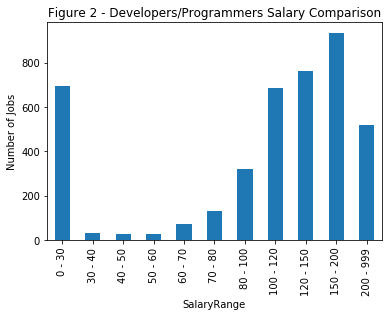

In [30]:
# Plot Developers/Programmers Data by calling the SalaryData function
temp_df = SalaryData(salary_count_df, 'Developers/Programmers').sort_values(by=['SalaryRange'])
temp_df = temp_df.reindex(index=RangeSort(temp_df.index))

ax = temp_df.plot.bar(title='Figure 2 - Developers/Programmers Salary Comparison', legend=False)
ax.set_ylabel('Number of Jobs')
ax

#### 1.1 Discussion
From looking at the raw data, there are examples of jobs that have conflicting salaries. Their full descriptions and the lowest and highest salaries differ and with the fact that all jobs have a lowest and highest salary it is clear that the range 0 - 30 is a default value that some job postings haven't changed. This can be clearly seen by looking at the data for the 'CEO' sub classification (Figure 1), it isn't realistic for so many jobs to be in the 0 - 30 range for such a demanding job. 

The ‘salary_count_df’ Data Frame allows us to generate histograms like the one for Developers/Programmers (Figure 2) showing the distribution of job postings by salary range. A function (called ‘SalaryData’) was created to obtain easy access to the salary range data for every sub classification that exists. The function takes ‘salary_count_df’, a sub class name and number of ranges to be returned in order of posting numbers. If the function is passed nothing it returns all the ranges to the function. 


#### 1.2 Where is the location of the sub class?

In [31]:
# Create DF containing counts of the jobs in each city grouped by their classification
loc_class_count_df = class_subclass_df.groupby(['Location', 'Classification']).count(
                        ).rename(columns = {'SubClassification' : 'Number of Jobs'})

loc_class_count_df.head()

Number of Jobs
Location Classification                                 
ACT      Accounting                                  180
         Administration & Office Support             319
         Advertising, Arts & Media                    22
         Banking & Financial Services                 47
         CEO & General Management                     22

In [32]:
# Access a particular cities job information, if n given top n jobs returned based on counts
def CityData(lc_df, city, n = 0):
    if n == 0:
        return lc_df.loc[city, :]
    else:
        return lc_df.loc[city, :].nlargest(n, 'Number of Jobs')


lc_df = CityData(loc_class_count_df, 'Melbourne', 5)

print('Figure 3 - City: Melbourne \n')
print(lc_df.head())

Figure 3 - City: Melbourne 

                                        Number of Jobs
Classification                                        
Information & Communication Technology            5889
Hospitality & Tourism                             4060
Trades & Services                                 3831
Manufacturing, Transport & Logistics              3556
Healthcare & Medical                              3493


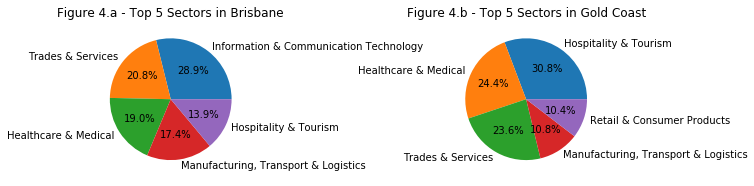

In [33]:
# Graphing a comparison between the top 5 sectors for Gold Coast and Brisbane 
fig1, ax = plt.subplots(1, 2)

lc_df = CityData(loc_class_count_df, 'Brisbane', 5)
ax[0].pie(lc_df['Number of Jobs'], labels=lc_df.index, autopct='%1.1f%%')
ax[0].set_title('Figure 4.a - Top 5 Sectors in Brisbane')

lc_df2 = CityData(loc_class_count_df, 'Gold Coast', 5)
ax[1].pie(lc_df2['Number of Jobs'], labels=lc_df2.index, autopct='%1.1f%%')
ax[1].set_title('Figure 4.b - Top 5 Sectors in Gold Coast')

box = ax[1].get_position()
box.x0 = box.x0 + 0.4
box.x1 = box.x1 + 0.4
ax[1].set_position(box)


plt.show()

#### 1.2 Discussion
The ‘loc_class_count_df’ is a data frame grouped by the location and classification, for each classification is shows the number of job postings at that location. The function ‘CityData()’ can access an individual cities classification posting information. It takes the ‘loc_class_count_df’, city name and number of classifications to return ordered by job postings as parameters. As hypothesised the most common jobs in the Gold Coast were in the Hospitality & tourism sector and in the same vein Brisbane has a lot of Information & Communication Technology job postings (Figure 4). The data also revealed that Melbourne (Figure 3), Brisbane and the Gold Coast had four sectors in common (Trades & Services, Hospitality & Tourism, Manufacturing, Transport & Logistics, and Healthcare & Medical).


#### 1.3 Classifying the Job Type using Categorical Data

In [34]:
job_type_df = orig_df[['Classification', 'SubClassification', 'LowestSalary', 'HighestSalary', 'JobType']].copy()
job_type_df = job_type_df.dropna()
job_type_df = job_type_df.reset_index()
job_type_df = job_type_df.drop(columns=['index'])

In [35]:
# Replace the text for classification with a categorical number
class_unique = np.sort(job_type_df['Classification'].unique())
class_dict = {}
for i in range(len(class_unique)):
    class_dict[class_unique[i]] = i

# Replace the text for sub classification with a categorical number
subclass_unique = np.sort(job_type_df['SubClassification'].unique())
subclass_dict = {}
for i in range(len(subclass_unique)):
    subclass_dict[subclass_unique[i]] = i
    
# Replace job type with a categorical number
job_unique = np.sort(job_type_df['JobType'].unique())
job_dict = {}
for i in range(len(job_unique)):
    job_dict[job_unique[i]] = i

for index, row in job_type_df.iterrows():
    job_type_df.at[index, 'Classification'] = class_dict[job_type_df.at[index, 'Classification']]
    job_type_df.at[index, 'SubClassification'] = subclass_dict[job_type_df.at[index, 'SubClassification']]
    job_type_df.at[index, 'JobType'] = job_dict[job_type_df.at[index, 'JobType']]

In [36]:
lbl = job_type_df['JobType']
job_type_df = job_type_df.drop(columns='JobType')
job_type_df.head()


,Classification,SubClassification,LowestSalary,HighestSalary
0,24,280,0,30
1,24,280,0,30
2,15,329,0,30
3,15,329,0,30
4,15,161,0,30


In [37]:
standardScaler = preprocessing.StandardScaler()
standardScaler.fit(job_type_df)
scaled = standardScaler.transform(job_type_df)
norm_df = pd.DataFrame(scaled, columns = job_type_df.columns)
norm_df.head()

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


,Classification,SubClassification,LowestSalary,HighestSalary
0,1.078173,1.171153,-1.302576,-0.472545
1,1.078173,1.171153,-1.302576,-0.472545
2,-0.022921,1.665834,-1.302576,-0.472545
3,-0.022921,1.665834,-1.302576,-0.472545
4,-0.022921,-0.030217,-1.302576,-0.472545


In [38]:
lbl = np.array(lbl).reshape(-1, 1)

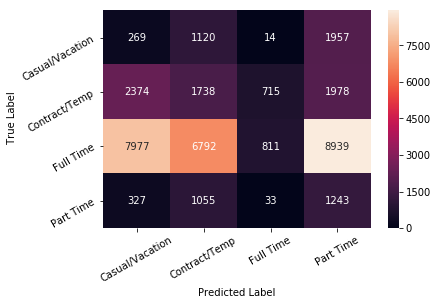

In [39]:
x_train, x_test, y_train, y_test = train_test_split(norm_df.values, lbl, test_size = 0.2,
                                                    random_state=4)

norm_kMCluster = cluster.KMeans(n_clusters = 4, random_state=0)
norm_kMCluster.fit(x_train, y_train)
norm_pred = norm_kMCluster.predict(x_test)
y_test = list(y_test.ravel())


con_matrix = metrics.confusion_matrix(y_test, norm_pred)
ax = sns.heatmap(con_matrix, annot=True, fmt="d")
ax.set(ylabel=' True Label', xlabel='Predicted Label')
ax.set_xticklabels(list(job_dict.keys()), rotation=30)
ax.set_yticklabels(list(job_dict.keys()), rotation=30)
ax

In [40]:
print(metrics.classification_report(y_test, norm_pred, target_names = list(job_dict.keys())))

                 precision    recall  f1-score   support

Casual/Vacation       0.02      0.08      0.04      3360
  Contract/Temp       0.16      0.26      0.20      6805
      Full Time       0.52      0.03      0.06     24519
      Part Time       0.09      0.47      0.15      2658

      micro avg       0.11      0.11      0.11     37342
      macro avg       0.20      0.21      0.11     37342
   weighted avg       0.38      0.11      0.09     37342



#### 1.3 Discussion
To be able to cluster and classify the job types of every posting first we need to convert the categorical columns (classification, subclassification and job type) into numerical values. Next the numerical values need to be normalised to make the K Means clustering more accurate. Overall the weighted average score for the K Means predictor is 38%, there are a few reasons as to why such a low accuracy score is the case. The first, as mentioned above in 1.1, some job postings have incorrect lowest / highest Salary ranges, this would make it harder for K Means to extract useful information from those two columns. The second issue involves the amount of data we have for each job type, for the testing set 65% of the data is Full Time. This means that the different job types are not represented equally and thus skews the model.   


### 2) Study the job market by locations

#### 2.1 What is the market size in each city? Which are the hottest job sectors in each city?



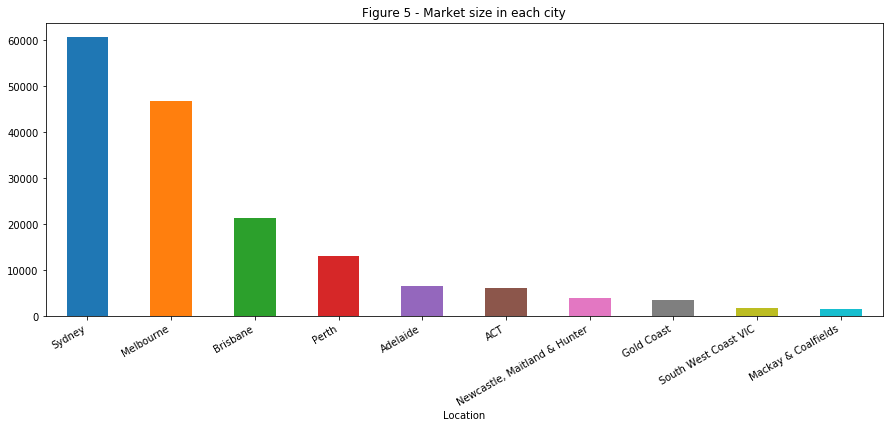

In [41]:
class_subclass_df = orig_df[['Location', 'Classification']].copy()
market_size = pd.DataFrame()
market_size['Number of Jobs'] = class_subclass_df.groupby('Location')['Classification'].count()
market_size.head()
f, ax = plt.subplots(figsize=(15, 6))
market_size['Number of Jobs'].sort_values(ascending=False).head(10).plot(kind='bar')
f.autofmt_xdate()
plt.title('Figure 5 - Market size in each city')
plt.show()

In [42]:
hottest_job_sec = orig_df[['Location', 'Classification']].copy()
hottest_job_sec = hottest_job_sec.groupby(['Location', 'Classification'])['Classification'].count() \
                .reset_index(name='Number of Jobs')

hottest_job_sec.sort_values(by=['Location','Number of Jobs'], ascending=[True, False], inplace=True)
hottest_job_sec = hottest_job_sec.drop_duplicates(subset='Location')
hottest_job_sec.sort_values(by='Number of Jobs', ascending=False).head(10)

,Location,Classification,Number of Jobs
1373,Sydney,Information & Communication Technology,9548
915,Melbourne,Information & Communication Technology,5889
275,Brisbane,Information & Communication Technology,2768
17,ACT,Information & Communication Technology,2057
1102,Perth,Trades & Services,1520
1123,"Port Hedland, Karratha & Pilbara","Mining, Resources & Energy",830
59,Adelaide,Trades & Services,819
869,Mackay & Coalfields,"Mining, Resources & Energy",611
621,Gold Coast,Hospitality & Tourism,609
1026,"Newcastle, Maitland & Hunter",Trades & Services,549


#### 2.1 Discussion
Sydney, Melbourne, Brisbane, Perth and Adelaide are the leading cities within the job market, being the cities with the most associated job postings. Within these leading cities, the most sought out jobs are within the Information and Communication Technology sector apart from Perth which heavily advertises Trades and Services.

#### 2.2 Which range of salary is common on each city? Where are the employees more well-paid?

In [43]:
salary_range_count = pd.DataFrame()
salary_range_count = salary_location_df.groupby(['Location', 'SalaryRange'])['SalaryRange'].count() \
                    .reset_index(name='Number of Jobs')

salary_range_count.sort_values(by=['Location','Number of Jobs'], ascending=[True, False], inplace=True)
salary_range_count = salary_range_count.drop_duplicates(subset='Location')
salary_range_count.sort_values(by=['Number of Jobs'], ascending=False).head(15)

,Location,SalaryRange,Number of Jobs
587,Sydney,0 - 30,11753
391,Melbourne,0 - 30,9510
109,Brisbane,0 - 30,4082
468,Perth,0 - 30,2707
11,Adelaide,0 - 30,1256
0,ACT,0 - 30,1071
276,Gold Coast,40 - 50,755
435,"Newcastle, Maitland & Hunter",0 - 30,753
554,South West Coast VIC,0 - 30,399
479,"Port Hedland, Karratha & Pilbara",0 - 30,385


In [44]:
range_df = orig_df[['Location', 'HighestSalary']] 
salary_average = pd.DataFrame()
salary_average = range_df.groupby(['Location'])['HighestSalary'].mean() \
                    .reset_index(name='Highest Average')

salary_average.sort_values(by=['Location','Highest Average'], ascending=[True, False], inplace=True)
#salary_range_count = salary_range_count.drop_duplicates(subset='Location')
salary_average.sort_values(by=['Highest Average'], ascending=False).head(5)

,Location,Highest Average
0,ACT,198.718240
45,Port Macquarie & Mid North Coast,149.605544
54,Sydney,134.751041
60,Western QLD,134.128405
57,"Tumut, Snowy & Monaro",133.081395


#### 2.2 Discussion 
When analysing the salary among Australian cities, it was prevelant that the most common salary range was 0 - 30K with 30 - 40K coming second and 40 - 50K appearing third. This could be due to the fact that a lot of employers are looking for casual or junior salary-based workers within their industries on the basis of importance for employment costs over experience. 

Answering the question of which city the employees are most well-paid, we took into account the average highest salary for each city and put them in descending order. It is evident that ACT, the capital city of Australia has the highest average salary advertised with Port Macquarie & Mid North Coast and Sydney following.

#### 2.3 Can you detect the pattern of posting

In [45]:
postings_df = orig_df[['Date']].copy()
postings_df['Day'] = pd.DatetimeIndex(postings_df['Date']).day
postings_df = postings_df.drop(columns=['Date'])
postings_df = postings_df.groupby(['Day'])['Day'].count().reset_index(name='Postings').sort_values(['Postings'], ascending=False)
postings_df.head()

,Day,Postings
0,1,24512
2,3,21804
1,2,18585
10,12,17503
3,4,16728


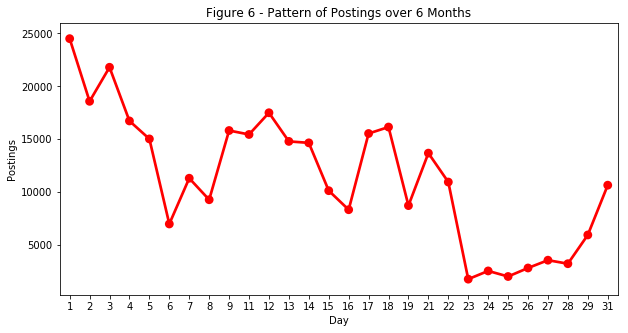

In [46]:
f, ax = plt.subplots(figsize=(10, 5))
sns.pointplot(x='Day', y='Postings', data=postings_df, color='r').set_title('Figure 6 - Pattern of Postings over 6 Months')
plt.show()

In [47]:
date_df = orig_df[['Date']].copy()
avg_postings_df = pd.DataFrame()
avg_postings_df['Month'] = pd.DatetimeIndex(date_df['Date']).month
avg_postings_df['Day'] = pd.DatetimeIndex(date_df['Date']).day
avg_postings_df = avg_postings_df.groupby(['Month', 'Day'])['Month'].count().groupby(['Day']).mean().reset_index(name='Average Postings').sort_values(['Average Postings'], ascending=False)
avg_postings_df.head()

,Day,Average Postings
0,1,4085.333333
1,2,3717.000000
2,3,3634.000000
27,31,3550.666667
16,18,3230.200000


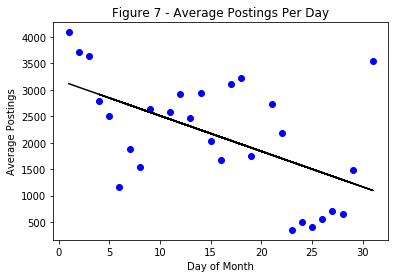

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score 
# Apply linear regression with the 'postings' feature to predict posting trend
model = LinearRegression()
y = avg_postings_df['Average Postings'].values
X = avg_postings_df[['Day']]

model.fit(X, y)
y_pred = model.predict(X)
posting_score = model.score(X, y)
plt.xlabel('Day of Month')
plt.ylabel('Average Postings')
plt.scatter(X, y, color='b')
plt.title('Figure 7 - Average Postings Per Day')
plt.plot(X, y_pred, color='black')

#### 2.3 Discussion
According to the analysis of job postings, the first three days of the month are the most popular days to post (refer to Figure 6), with the first day being the most advertised. There are a number of reasons why this could've ocurred but due to the fact that by posting on the first day of the month, employers can expect to have maximised their employee applications by the end of the month. 

The summation of postings over the 6 months (Figure 6) is proposed to be not as accurate as taking the number of postings per day and averaging them across the months. This is due to the fact that it does not take in outliers or influnctuation of postings of a particular day for a particular month. Therefore, in the "avg_postings_df" dataframe it can be seen that apart from the first three days of the month, the last day of the month is also frequently posted. There may be posting traffic at the beginning of the month mainly but it is evident that the last day can also contribute to the pattern. 

It is further evidenced in Figure 7 where the prediction of future postings per day also occur highest around days 1-3 and 31 of the month.

### 3) Study the market by sectors 

#### 3.1 In each sector, which sub-sectors are the main spotlights?

In [49]:
salary_class_df = salary_df.groupby(['Classification', 'SubClassification']).count(
                    ).rename(columns = {'SalaryRange' : 'Count'}).sort_values(['Count'], ascending=False)
salary_class_df.head(10)

,,Count
Classification,SubClassification,
Hospitality & Tourism,Chefs/Cooks,4600
Administration & Office Support,Administrative Assistants,4572
Information & Communication Technology,Developers/Programmers,4211
Retail & Consumer Products,Retail Assistants,3902
Government & Defence,Government - State,3701
"Manufacturing, Transport & Logistics","Warehousing, Storage & Distribution",3636
Sales,Sales Representatives/Consultants,3370
Trades & Services,Automotive Trades,3262
Information & Communication Technology,Business/Systems Analysts,2986


In [50]:
seen_class = set()
spotlight_df = pd.DataFrame(columns=['Classification', 'Spotlight'])

# Loop through the salary_class_df and find the highest sub class for each class
for row in salary_class_df.iterrows():
    classification = row[0][0]
    subclass = row[0][1]
    count = row[1]['Count']
    
    if classification not in seen_class:
        seen_class.add(classification)
        spotlight_df = spotlight_df.append({'Classification': classification, 
                            'Spotlight' : subclass}, ignore_index=True)

spotlight_df.sort_values('Classification')    

,Classification,Spotlight
15,Accounting,Financial Accounting & Reporting
1,Administration & Office Support,Administrative Assistants
28,"Advertising, Arts & Media",Agency Account Management
20,Banking & Financial Services,Compliance & Risk
22,CEO & General Management,General/Business Unit Manager
11,Call Centre & Customer Service,Customer Service - Call Centre
12,Community Services & Development,Aged & Disability Support
13,Construction,Project Management
25,Consulting & Strategy,Management & Change Consulting
23,Design & Architecture,Architecture


#### 3.1 Discussion
The data frame ‘salary_class_df’ was created to show the number of job postings for every sub classification along with their respective classification. This makes it easier to find the spotlights for every classification (the sub classifications that have the most job postings). ‘spotlight_df’ contains all the spotlights mentioned in a data frame, it can be used to easily search for the most popular sub classifications. 

#### 3.2 What is the salary range for each sector/sub-sector? Can you compare salary range between sectors/subsectors?

In [51]:
print("Figure 8 - Account & Relationship Management")
print(salary_count_df.head())

Figure 8 - Account & Relationship Management
                                               Number of Jobs
SubClassification                 SalaryRange                
Account & Relationship Management 0 - 30                  409
                                  100 - 120               241
                                  70 - 80                 230
                                  80 - 100                227
                                  60 - 70                 215


In [52]:
avg_salary_df = pd.DataFrame(columns=['Classification', 'SubClassification', 'Avg Salary'])

# Function that returns the classification for a particular sub classification
def GetClass(df, subclass):
    return df[df['SubClassification'] == subclass].Classification.values[0]

range_avg = { '0 - 30' : 15, '30 - 40' : 35, '40 - 50' : 45, '50 - 60' : 55,  '60 - 70' : 65,
    '70 - 80' : 75, '80 - 100' : 90, '100 - 120' : 110, '120 - 150' : 135, '150 - 200' : 175,
    '200 - 999' : 599.5}


current = salary_count_df.index[0][0]
sums = 0
total_jobs = 0

# Loop to create a average salary data frame  
for row in salary_count_df.iterrows():
    subclass = row[0][0]
    # If we have reached a new subclass to sum up calculate the average and append to the data frame
    if subclass != current:
        sums = sums / total_jobs
        avg_salary_df = avg_salary_df.append({'Classification': GetClass(salary_df, current),
                                              'SubClassification': current,
                                             'Avg Salary': sums}, ignore_index=True)
        current = subclass
        sums = 0
        total_jobs = 0
        
    
    rng = row[0][1]
    count = row[1]['Number of Jobs']
    sums += range_avg[rng] * count
    total_jobs += count
    
avg_salary_df.sort_values(by='Avg Salary', ascending=False).head(10)

,Classification,SubClassification,Avg Salary
132,Healthcare & Medical,General Practitioners,412.234759
197,Healthcare & Medical,Medical Specialists,367.311497
50,CEO & General Management,COO & MD,343.392157
49,CEO & General Management,CEO,311.245399
17,Information & Communication Technology,Architects,282.348191
257,Information & Communication Technology,Programme & Project Management,252.101741
133,CEO & General Management,General/Business Unit Manager,248.575000
249,Government & Defence,Police & Corrections,243.220339
68,Accounting,Company Secretaries,225.684211
79,Banking & Financial Services,Corporate Finance & Investment Banking,210.496894


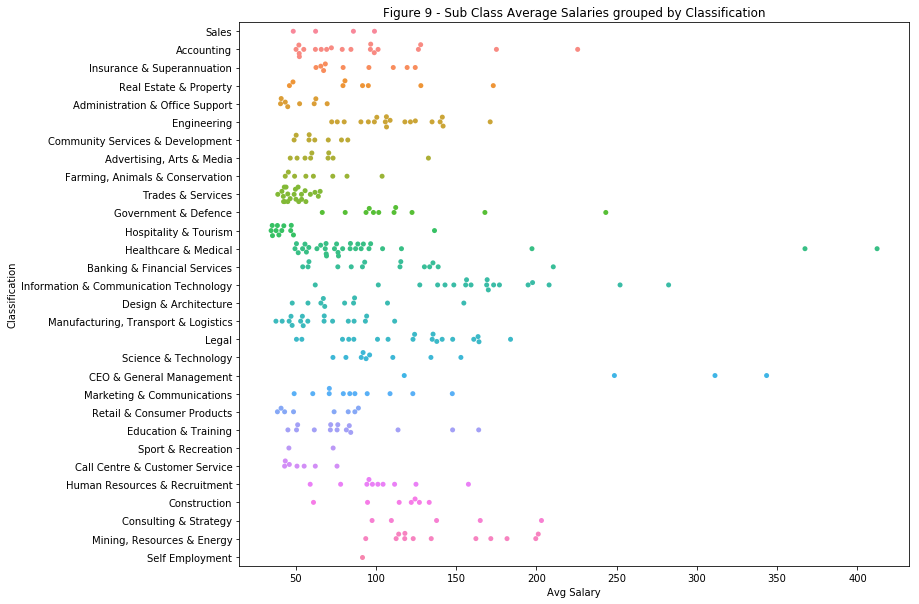

In [53]:
plt.figure(figsize=(12, 10))
ax = sns.swarmplot(x="Avg Salary", y="Classification", data=avg_salary_df)
ax.set_title("Figure 9 - Sub Class Average Salaries grouped by Classification")
ax

#### 3.2 Discussion
The method of calculating the average salary for each sub classification involves first averaging the salary ranges themselves and then multiplying them by the number of jobs within that particular range. From Figure 8 the 0 – 30k range would be averaged to 15k and multiplied by 409 for the ‘Accounting & Relationship Management’ sub class. A dictionary all ‘range_avg’ was created to make access to the average of ranges easier. All the range averages are summed up and then divided by the total number of jobs to give the sub class average salary.

Using the average salary data Figure 9 was created to represent the distribution of salaries for each of the classifications as a swarm plot. The graph allows us to see where the mode salaries lie for every classification. For example, ‘Information and Communication Technology’ jobs hover between the 150k and 200k salary range, there are also some outliers past 250k. It should be noted that the salary range of 200k – 999k skews the data at the high end of the salary averages. Because it has such a big distance between the salary low and high (799k) the average salaries above 200k are not very accurate. For example, the GP average salary isn’t going to be 412k a year (closer to 200k – 300k) but because the average of the range is 599.5k it brings it up.


#### 3.3 What is the trending of market i.e. if a high school student asked you which subject should he/she learn in university (to guarantee a job in the future), what is your advice?

In [54]:
subclass_df = orig_df[['Date','SubClassification']].copy()
top5 = subclass_df.groupby(['SubClassification'])['SubClassification'].count().sort_values(ascending=False).head(6)
subclass_df['Month'] = pd.DatetimeIndex(subclass_df['Date']).month
#subclass_df = subclass_df.drop(columns=['Date'])
subclass_df = subclass_df.groupby(['SubClassification', 'Month'])['SubClassification'].count().reset_index(name='Postings').sort_values(['Postings'], ascending=False)
print(top5)

SubClassification
Other                        11349
Management                    6236
Chefs/Cooks                   4600
Administrative Assistants     4572
Developers/Programmers        4211
Retail Assistants             3902
Name: SubClassification, dtype: int64


In [55]:
#subclass_df = subclass_df[subclass_df.Month != 3]
ls = ['Management', 'Chefs/Cooks', 'Administrative Assistants',
                                                     'Developers/Programmers', 'Retail Assistants']
subclass_df[subclass_df['SubClassification'].isin(ls)]
chosen_subclass_df = subclass_df[subclass_df['SubClassification'] == 'Developers/Programmers']

chosen_subclass_df = chosen_subclass_df.sort_values(by='Month')
chosen_subclass_df.head()

,SubClassification,Month,Postings
263,Developers/Programmers,10,2408
264,Developers/Programmers,11,789
265,Developers/Programmers,12,1014


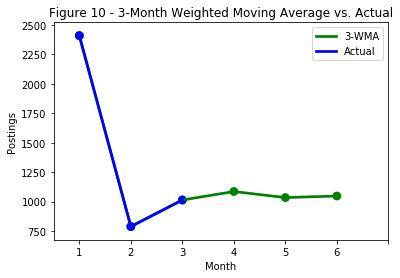

In [56]:
# Using weighted moving average
def movingAvg(data, n):
    pred = data[:]
    for i in range(0, n):
        x_1 = pred[-1] * 0.6
        x_2 = pred[-2] * 0.3
        x_3 = pred[-3] * 0.1
        avg = (x_1 + x_2 + x_3)
        pred.append(avg)
    return pred

f, ax = plt.subplots(1, 1)
mv_avg = movingAvg(list(chosen_subclass_df['Postings'].values), 3)
chosen_subclass_df['Month'] = [1,2,3]
mv_avg_df = pd.DataFrame()
mv_avg_df['Postings'] = mv_avg
mv_avg_df['Month'] = [1,2,3,4,5,6]

sns.pointplot(x='Month', y='Postings', data=mv_avg_df, color='g')
sns.pointplot(x='Month', y='Postings', data=chosen_subclass_df, color='b')
ax.legend(handles=ax.lines[::len(mv_avg_df)+1], labels=["3-WMA", "Actual"])
plt.xticks(range(len(mv_avg_df['Month'])+1) , mv_avg_df['Month'])
plt.title('Figure 10 - 3-Month Weighted Moving Average vs. Actual')
plt.show()

#### 3.3 Discussion
To identify what subjects would help a student deciding on her career path, it was necessary to first identify the leading job subclassifications (classifications were too general). The leading subclassifications were Management, Chefs/Cooks, Administrative Assistants, Developers/Programmers and Retail Assistants. We would need more information about the student to really come to a more precise conclusion. However, looking at the previous information we revealed about the most prominent job classifications among cities, Information & Communication Technology rated the highest among major cities within Australia. Due to this factor, the postings for Developers/Programmers were predicted for the next three months using a Forecasting technique - Weighted Moving Average. It would be smart to study programming if they wanted to guarantee a job in the future. 

# Part 3 - Evaluation

### Part 1) What are the findings of your data analytics?

The hypothesis regarding the salary of software developers was accurate, as can be seen from figure 2 the salaries are right skewed. With most jobs being between 80 – 999 ranges, there is a peek on left for the range 0 - 30 this likely includes both part-time / casual positions as well as posting which have not updated their range correctly.  

Using K Means clustering and the attributes classification, subclassification, lowest salary and highest salary the classifier was not able to perform to the expected accuracy (predicted 60% accuracy, actual 38%), as mentioned before the main reasons for this being inaccurate data (salary ranges) and non-equal representations of job types.

The assumption for the Information & Communication Technology sector was correct, the data set had 4211 jobs in the Developers/Programmers sub classification. However, the actual highlights for Trades & Services was ‘Automotive Trades’ at 3262 postings (not plumbing), 4600 Chefs/Cooks were sought after (the most of any sector) in Hospitality & Tourism.
Due to the formatting of the salary ranges for jobs the prediction that CEO & General Management would be have the highest average salary isn’t verified by the data. This is likely caused by the fact that jobs earning over \$200 000 are also lumped in with jobs earning over $1 million thus the sector with more postings in the 200 – 999 range would have a higher average salary even if the jobs in actuality on the lower end of the spectrum.

The initial insight about market size within each city was that Melbourne, Sydney, Brisbane and ACT would have the highest market share size within Australia. Sydney, Melbourne, Brisbane, Perth and Adelaide were found to be the leading cities in the job market where they had the most advertised jobs within SEEK. 

When analysing job sectors by location, we wanted to find out the most advertised job sector within each city. We hypothesized that for Melbourne it would be Information and Communication Technology, for the Gold Coast it would be Hospitality or Trades & Services, for Brisbane it would be Information and Communication Technology and Transport Services, and for Sydney it would be Information Communication Technology or Real Estate. The analysis found that our hypothesis was correct for Melbourne, Gold Coast (only for Hospitality), Brisbane (only for Information Communication Technology) and Sydney (only for Information Communication Technology)
 
An important question when looking at job markets within Australia is where is the income the highest for the job I want? We figued that Sydney would have the highest average salary since their living costs are high. The results show that ACT had an average highest salary of 198K and Sydney actually had an average of 134K. 

The pattern of posting was analysed to give insight into when employers would preferably posting their lastest job offering. We predicted that these postings would occur at the beginning of the month due to the fact that it would give the employers the 'rest of the month' for applications. The analysis resulted in a trend of mainly the 1st, 2nd and 3rd day with the most postings, and the last day of the month too. In considering this, the last day of the month is right before the start of the month and therefore, the hypothesis would still apply as those four days are only one day after another. 

We predicted that the most popular jobs in the future would be marketing or advertising, programming, architecture of business/system analyst. The findings shows us that the most popular job sub-sector being advertised was actually management, chefs/cook

### Part 2) What actions for balancing the markets do you suggest based on your findings?
Education departments should expose students to different job sectors, especially emerging fields such as Information and Communication Technology. This will enable our population to fill in the tens of thousands of jobs in the IT sector. Hundreds of IT jobs that do not get filled endup being exported overseas costing the Australian economy. Currently the education system focuses on the traditional subjects like English, Mathematics and Science, however the job market calls for skills within IT especially programming and development.

In figure 9 it shows that Advertisements, Arts & Media are in the same pay range (50 - 100) as Trades & Services. Unless a persons focus is Performing Arts (which is in the 100 - 150 average salary range) it would be more benefical to take up a trade. For one, most trades offer an apprenticeship which allows the person to earn money from the get go unlike a university degree which actually costs money. Secondly, at a standard university a minimum of 3 years is  require for an Arts & Media degree if the student is full time (in the case of someone who has to financially suport themselves this can extend to 6 years). The government promoting Trades & Services as a viable career path with help fill in the gaps in the sector.

### Part 3) How could you refine your data analytics? 

#### 3.1 Could you use different data sources?
The data set provided was gathered from seek.com using a web scraper, the same technique could also be applied to multiple other job posting sites such as jora, indeed, job seeker. The data analysis could be made more specialised for example looking at government job postings only using jobsearch.gov or provide specific analysis for graduates seeking jobs in their respective fields i.e. gradconnection. 

#### 3.2 Could you choose different parameters?
For analysising the job market by locations, subclassification could have been used instead of classification to create a more specific highlight into what relevant skills and knowledge is needed for different cities when diving into the job market.

#### 3.3 Could you choose other techniques?
There are many other clustering algorithms that could have been chosen instead of K Means such as Support Vector Machine and Naïve Bayes classifiers.

Seasonality is one of the more precise techniques in forecasting and if we had enough data (at least one year's worth), it would've been more accurate to apply the seasonality method against the time series data when making a prediction.
	
#### 3.4 Can you think of ways to obtain more relevant data?
As mentioned before a word parser to determine the actual salary range of jobs which left it at the default value would provide more relevant data likely improving the job type classifier. To get a better representation of the average salaries of jobs the addition of more salary ranges in the 200 – 999 range would also be beneficial.

Due to the nature of a job posting website, as soon as a job has been closed it is removed from the visbility of users. The timeline of data obtained in one web scraping (based on this data) is around 6 months. To obtain enough data to do a year's analysis we would need to grab data from SEEK two times per year. It would also be beneficial to do an analysis straight after obtaining data to immediately predict future trends. 

### Part 4) Are there any implications for employers and employees based on the findings you obtained? Justify answer.
#### Employers
If you're posting a job within a competitive sector, it is important to list the correct salary range as employees will sometimes filter by the salary and your posting will not be present. Also it is important to have competitive pricing and an interesting description when posting within a high market share sector as the highest priced advertised job and employee benefits would have the most applicants when applying for the same sub-sector. 

#### Employees
It is beneficial to look at different cities when applying within a particular job sector as some cities offer more salary for the same job sub-sector and experience. The most prominent sector within major cities falls under Information and Communication Technology, if an employee wanted to be able to have a vast variety of options within a particular sector they would study IT. If you are needing to earn money straight away, the second most advertised job is management (which can be acquired through experience in the industry) or chefs/cooks which may require a paid apprenticeship or in some cases just some form of experience.  